In [1]:
!pip install git+https://github.com/konstmish/opt_methods.git

  Cloning https://github.com/konstmish/opt_methods.git to /private/var/folders/1r/dhtw1ntj2klfnlqmdcmdbtcm71p3bh/T/pip-req-build-s5eeo08u
  Created wheel for opt-methods: filename=opt_methods-0.1.1-py3-none-any.whl size=53038 sha256=4e5189f3b513b278f626288aa21bf4e078a8c8084c53625690ab20892e1a06d8
  Stored in directory: /private/var/folders/1r/dhtw1ntj2klfnlqmdcmdbtcm71p3bh/T/pip-ephem-wheel-cache-21sk_jyt/wheels/bf/b4/48/3c91e0f1794f4eeba87acece649fcbd94f4b9a93674874633b
Successfully built opt-methods


In [2]:
!pip install -U ray

Requirement already up-to-date: ray in /opt/anaconda3/lib/python3.8/site-packages (1.12.1)


In [3]:
import matplotlib
import numpy as np
import psutil
import ray
import seaborn as sns

import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
from sklearn.datasets import load_svmlight_file, fetch_rcv1

from optmethods.datasets import get_dataset
from optmethods.first_order import Adgd, Gd, Nesterov, RestNest
from optmethods.loss import LogisticRegression
from optmethods.utils import get_trace, relative_round

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)
# Multiple plots in one figure: code below
# import matplotlib.backends.backend_pdf as bf
# <code for plt>
# pdf = bf.PdfPages("./output.pdf")
# for fig in xrange(1, plt.figure().number):
#         pdf.savefig( fig )
# pdf.close()

In [4]:
num_cpus = psutil.cpu_count(logical=False)
# ray.init(num_cpus=num_cpus)

## Get data and define problem

In [5]:
import sklearn.datasets
import urllib.request
w8a_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"
a9a_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a"
data_path = './w8a'
f = urllib.request.urlretrieve(w8a_url, data_path)
# f = urllib.request.urlretrieve(a9a_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)

n, dim = A.shape
if n % num_cpus != 0:
    A = A[:n - (n % num_cpus)]
    b = b[:n - (n % num_cpus)]
b_unique = np.unique(b)
if (b_unique == [1, 2]).all():
    # Transform labels {1, 2} to {0, 1}
    b = b - 1
elif (b_unique == [-1, 1]).all():
    # Transform labels {-1, 1} to {0, 1}
    b = (b+1) / 2
else:
    # replace class labels with 0's and 1's
    b = 1. * (b == b[0])
# A = A.toarray()
l1 = 0
loss = LogisticRegression(A, b, l1=l1, l2=0)
n, dim = A.shape
if n <= 20000 or dim <= 20000:
    print('Computing the smoothness constant via SVD, it may take a few minutes...')
L = loss.smoothness
# l2 = 0
l2 = 1e-3 * L
loss.l2 = l2
# x0 = csc_matrix((dim, 1))
x0 = np.zeros(dim)
n_epoch = 100
# it_max = (n_epoch * n) // batch_size
trace_len = 300

print(L, l2)

Computing the smoothness constant via SVD, it may take a few minutes...
0.6611558746661748 0.0006611558746661747


## Solve problem by Nesterov's method

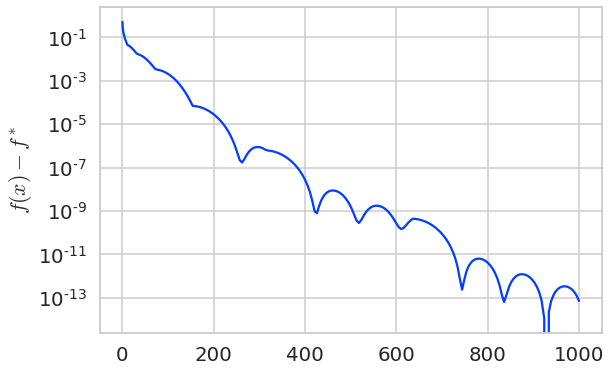

In [7]:
rest = RestNest(loss=loss, doubling=True)
rest_tr = rest.run(x0=x0, it_max=1000)
rest_tr.compute_loss_of_iterates()
rest.trace.plot_losses()
plt.yscale('log')

## Define local methods

### Local SGD

In [8]:
from optmethods.optimizer import StochasticOptimizer


@ray.remote
class Worker:
    def __init__(self, shuffle=True, prox_skip=False, loss=None, it_local=None, batch_size=1):
        self.loss = loss
        self.shuffle = shuffle
        self.prox_skip = prox_skip
        self.it_local = it_local
        self.batch_size = batch_size
        self.c = None
        self.h = None
        self.rng_skip = np.random.default_rng(42) # random number generator for random synchronizations
    
    def run_local(self, x, lr):
        self.x = x * 1.
        if self.shuffle:
            self.run_local_shuffle(lr)
        elif self.prox_skip:
            print(f"running prox skip with x={x}")
            self.run_prox_skip(lr)
        else:
            self.run_local_sgd(lr)
        return self.x
    
    def run_local_shuffle(self, lr):
        permutation = np.random.permutation(self.loss.n)
        i = 0
        while i < self.loss.n:
            i_max = min(self.loss.n, i + self.batch_size)
            idx = permutation[i:i_max]
            self.x -= lr * self.loss.stochastic_gradient(self.x, idx=idx)
            i += self.batch_size
    
    def run_local_sgd(self, lr):
        for i in range(self.it_local):
            if self.batch_size is None:
                self.x -= lr * self.loss.gradient(self.x)
            else:
                self.x -= lr * self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
    
    def run_scaffold(self, x, lr, c):
        # as in the original scaffold paper, we use their Option II
        self.x = x * 1.
        if self.c is None:
            self.c = self.x * 0. #initialize zero vector of the same dimension
        for i in range(self.it_local):
            if self.batch_size is None:
                g = self.loss.gradient(self.x)
            else:
                g = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (g - self.c + c)
        self.c += 1 / (self.it_local * lr) * (x - self.x) - c
        return self.x

    def run_prox_skip(self, lr):
        p = 1 / self.it_local
        if self.h is None:
            # first iteration
            self.h = self.x * 0. # initialize zero vector of the same dimension
        else:
            # update the gradient estimate 
            self.h += p / self.lr * (self.x - self.x_before_averaing)
        it_local = self.rng_skip.geometric(p=p) # since all workers use the same random seed, this number is the same for all of them

        for i in range(it_local):
            if self.batch_size is None:
                g = self.loss.gradient(self.x)
            else:
                g = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (g - self.h)
        self.x_before_averaing = self.x * 1.
    
    def get_control_var(self):
        return self.c


class LocalSgd(StochasticOptimizer):
    """
    Stochastic gradient descent with decreasing or constant learning rate.
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, cohort_size=None, iid=False, lr0=None, lr_max=np.inf, lr_decay_coef=0,
                 lr_decay_power=1, it_start_decay=None, batch_size=1, losses=None, *args, **kwargs):
        super(LocalSgd, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        
        if self.cohort_size == self.n_workers:
            self.x = np.mean(ray.get([worker.run_local.remote(x_id, self.lr) for worker in self.workers]), axis=0)
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            self.x = np.mean(ray.get([self.workers[i].run_local.remote(x_id, self.lr) for i in cohort]), axis=0)
    
    def init_run(self, *args, **kwargs):
        super(LocalSgd, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        if self.lr0 is None:
            self.lr0 = 1 / self.loss.batch_smoothness(batch_size)
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def update_trace(self, first_iterations=10):
        super(LocalSgd, self).update_trace()
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)

### FedRR

In [9]:
import math

class LocalShuffling(StochasticOptimizer):
    """
    Shuffling-based stochastic gradient descent with decreasing or constant learning rate.
    For a formal description and convergence guarantees, see
        https://arxiv.org/abs/2006.05988
    
    The method is sensitive to finishing the final epoch, so it will terminate earlier 
    than it_max if it_max is not divisible by the number of steps per epoch.
    
    Arguments:
        reshuffle (bool, optional): whether to get a new permuation for every new epoch.
            For convex problems, only a single permutation should suffice and it can run faster (default: False)
        prox_every_it (bool, optional): whether to use proximal operation every iteration 
            or only at the end of an epoch. Theory supports the latter. Only used if the loss includes
            a proximal regularizer (default: False)
        lr0 (float, optional): an estimate of the inverse smoothness constant, this step-size
            is used for the first epoch_start_decay epochs. If not given, it will be set
            with the value in the loss.
        lr_max (float, optional): a maximal step-size never to be exceeded (default: np.inf)
        lr_decay_coef (float, optional): the coefficient in front of the number of finished epochs
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/3, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished epochs
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        epoch_start_decay (int, optional): how many epochs the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, n_workers=None, iid=False, reshuffle=False, lr0=None, lr_max=np.inf, lr_decay_coef=0,
                 lr_decay_power=1, epoch_start_decay=1, batch_size=1, 
                 losses=None, jumping=0, cohort_size=None, *args, **kwargs):
        super(LocalShuffling, self).__init__(*args, **kwargs)
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.reshuffle = reshuffle
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.epoch_start_decay = epoch_start_decay
        self.batch_size = batch_size
        self.losses = losses
        self.jumping = jumping
        
        if self.iid:
            self.steps_per_epoch = math.ceil(self.loss.n/batch_size)
        else:
            self.steps_per_epoch = math.ceil(self.loss.n/batch_size/n_workers)
        if epoch_start_decay is None and np.isfinite(self.epoch_max):
            self.epoch_start_decay = 1 + self.epoch_max // 40
        elif epoch_start_decay is None:
            self.epoch_start_decay = 1
        
    def step(self):
        if self.it%self.steps_per_epoch == 0 and self.reshuffle:
            # Start new epoch
            self.permutation = np.random.permutation(self.loss.n)
            self.i = 0
            self.sampled_permutations += 1
        idx_perm = np.arange(self.i, min(self.loss.n, self.i+self.batch_size))
        idx = self.permutation[idx_perm]
        self.i += self.batch_size
        # since the objective is 1/n sum_{i=1}^n f_i(x) + l2/2*||x||^2
        # any incomplete minibatch should be normalized by batch_size
        normalization = self.loss.n / self.steps_per_epoch
        self.grad = self.loss.stochastic_gradient(self.x, idx=idx, normalization=normalization)
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.loss.n/self.batch_size*self.lr_decay_coef*max(0, self.finished_epochs-self.epoch_start_decay)**self.lr_decay_power)
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        if self.cohort_size == self.n_workers:
            x_new = np.mean(ray.get([worker.run_local.remote(x_id, self.lr) for worker in self.workers]), axis=0)
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            x_new = np.mean(ray.get([self.workers[i].run_local.remote(x_id, self.lr) for i in cohort]), axis=0)
        if self.jumping:
            full_grad_estim = (self.x - x_new) / self.lr
            self.gd_lr = self.lr * (1 + self.jumping)
            self.x = self.x - self.gd_lr * full_grad_estim
            self.jumping_sum += self.jumping_coef
        else:
            self.x = x_new
        self.finished_epochs += 1
    
    def init_run(self, *args, **kwargs):
        super(LocalShuffling, self).init_run(*args, **kwargs)
        if self.lr0 is None:
            self.lr0 = 1 / self.loss.batch_smoothness(batch_size)
        self.finished_epochs = 0
        self.permutation = np.random.permutation(self.loss.n)
        self.sampled_permutations = 1
        self.epoch_max = self.it_max // self.steps_per_epoch
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=True, loss=loss_id, it_local=None, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=True, loss=loss, it_local=None, batch_size=self.batch_size) for loss in loss_ids]
        self.jumping_sum = 0
        self.gd_lr = None
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)

### Scaffold

In [10]:
class Scaffold(StochasticOptimizer):
    """
    Scaffold (local SGD with variance control).
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, iid=False, lr0=None, lr_max=np.inf, 
                 lr_decay_coef=0, lr_decay_power=1, it_start_decay=None,
                 batch_size=1, losses=None, global_lr=1., cohort_size=None, *args, **kwargs):
        super(Scaffold, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        self.global_lr = global_lr
        
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf 
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        c_id = ray.put(self.c)
        if self.cohort_size == self.n_workers:
            x_new = np.mean(ray.get([worker.run_scaffold.remote(x_id, self.lr, c_id) for worker in self.workers]), axis=0)
            c_new = np.mean(ray.get([worker.get_control_var.remote() for worker in self.workers]), axis=0)
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            x_new = np.mean(ray.get([self.workers[i].run_scaffold.remote(x_id, self.lr, c_id) for i in cohort]), axis=0)
            c_new = np.mean(ray.get([self.workers[i].get_control_var.remote() for i in cohort]), axis=0)
        if self.global_lr == 1:
            self.x = x_new
        else:
            self.x += self.global_lr * (x_new - self.x)
        self.c += self.cohort_size / self.n_workers * (c_new - self.c)
    
    def init_run(self, *args, **kwargs):
        super(Scaffold, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        self.c = self.x * 0
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)


## FedLin

In [11]:
class Fedlin(StochasticOptimizer):
    """
    Fedlin (local SGD with variance control and linear convergence).
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, iid=False, lr0=None, lr_max=np.inf, 
                 lr_decay_coef=0, lr_decay_power=1, it_start_decay=None,
                 batch_size=1, losses=None, global_lr=1., cohort_size=None, *args, **kwargs):
        super(Fedlin, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        self.global_lr = global_lr
        
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf 
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        if self.cohort_size != self.n_workers:
            raise ValueError("There is no theory for FedLin with partial participation. This feature is not implemented.")
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
        g = np.mean(ray.get([worker.get_fedlin_grad.remote(x_id) for worker in self.workers]), axis=0)
        g_id = ray.put(g)
        if self.cohort_size == self.n_workers:
            self.x = np.mean(ray.get([worker.run_fedlin.remote(x_id, self.lr, g_id) for worker in self.workers]), axis=0)
        else:
            self.x = np.mean(ray.get([self.workers[i].run_fedlin.remote(x_id, self.lr, c_id) for i in cohort]), axis=0)
    
    def init_run(self, *args, **kwargs):
        super(Fedlin, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)


# Non-iid

In [26]:
cohort_size = 18 # CHANGE IF YOU WANT PARTIAL PARTICIPATION
n_workers = 20
n_seeds = 1
batch_size = None

In [27]:
# permutation = A[:, 0].A.squeeze().argsort()
permutation = b.squeeze().argsort()

losses = []
idx = [0] + [(n * i) // n_workers for i in range(1, n_workers)] + [n]
for i in range(n_workers):
    idx_i = permutation[idx[i] : idx[i+1]]
    # idx_i = range(idx[i], idx[i + 1])
    loss_i = LogisticRegression(A[idx_i].A, b[idx_i], l1=0, l2=l2)
    loss_i.computed_grads = 0
    losses.append(loss_i)

/opt/anaconda3/lib/python3.8/site-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


In [28]:
grad_norms = [np.linalg.norm(loss_i.gradient(loss.x_opt))**2 for loss_i in losses]
print(np.mean(grad_norms))

0.004939143752337777


In [ ]:
if batch_size is not None:
    it_local = (n-1) // batch_size + 1
    sgd_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) / it_local
    it_max = n*5//(batch_size*it_local)
else:
    it_local = 20
    sgd_lr0 = 1 / loss.smoothness
    it_max = 100
    
sgd_decay_coef = l2 / 2
sgd_lr_max = sgd_lr0
sgd = LocalSgd(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=sgd_lr_max, lr0=sgd_lr0, lr_decay_coef=sgd_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
sgd.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
sgd.trace.compute_loss_of_iterates()
sgd.terminate_workers()

2022-01-24 01:08:20,302	WARNING worker.py:1245 -- WARNING: 4 PYTHON worker processes have been started on node: 03708718d92137dbe6e211d3492bce38d91c748d5bf3ec2cb3e1a5fd with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-01-24 01:08:21,165	WARNING worker.py:1245 -- WARNING: 5 PYTHON worker processes have been started on node: 03708718d92137dbe6e211d3492bce38d91c748d5bf3ec2cb3e1a5fd with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-01-24 01:08:22,061	WARNING worker.py:1245 -- WARNING: 6 PYTHON worker processes have been started on node: 03708718d92137dbe6e211d3492bce38d91c748d5bf3ec2cb3e1a5fd with address: 172.28.0.2. This could be a result of using a l

In [ ]:
if batch_size is not None:
    it_local = rr.steps_per_epoch
    scah_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) / it_local
    it_max=n*5//(batch_size*it_local)
    scah_decay_coef = l2 / 2
else:
    it_local = 300 # use the value used for Local SGD
    scah_lr0 = 1 / loss.smoothness
    it_max = 10000 # use the value used for Local SGD
    scah_decay_coef = 0 # no need to decrease the stepsize if full gradients are used
scah_lr_max = scah_lr0
scah = Scaffold(loss=loss, n_workers=n_workers, it_local=it_local, lr_max=scah_lr_max, lr0=scah_lr0, lr_decay_coef=scah_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
scah.run(x0=x0, it_max=it_max)
scah.trace.compute_loss_of_iterates()
scah.terminate_workers()

ValueError: ignored

## Results for theoretical stepsizes (1 / (L * H))

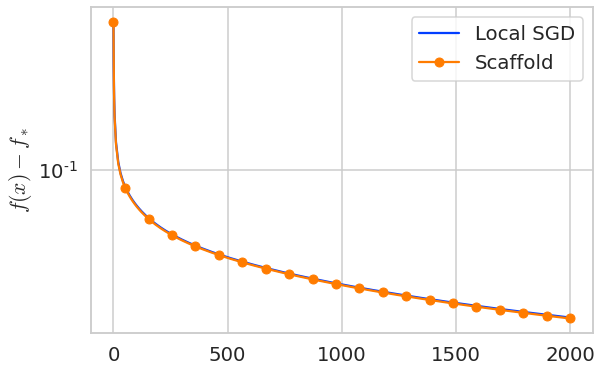

In [ ]:
sgd.trace.plot_losses(label='Local SGD', marker=',')
scah.trace.plot_losses(label='Scaffold', marker='o')
if batch_size is not None:
    rr.trace.plot_losses(label='FedRR', marker='*', color='red')
plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.legend()

In [15]:
@ray.remote
class Worker:
    def __init__(self, shuffle=True, prox_skip=False, loss=None, it_local=None, batch_size=1):
        self.loss = loss
        self.shuffle = shuffle
        self.prox_skip = prox_skip
        self.it_local = it_local
        self.batch_size = batch_size
        self.c = None
        self.h = None
        self.rng_skip = np.random.default_rng(42) # random number generator for random synchronizations
    
    def run_local(self, x, lr):
        self.x = x * 1.
        if self.shuffle:
            self.run_local_shuffle(lr)
        elif self.prox_skip:
            self.run_prox_skip(lr)
        else:
            self.run_local_sgd(lr)
        return self.x
    
    def run_local_shuffle(self, lr):
        permutation = np.random.permutation(self.loss.n)
        i = 0
        while i < self.loss.n:
            i_max = min(self.loss.n, i + self.batch_size)
            idx = permutation[i:i_max]
            self.x -= lr * self.loss.stochastic_gradient(self.x, idx=idx)
            i += self.batch_size
    
    def run_local_sgd(self, lr):
        for i in range(self.it_local):
            if self.batch_size is None:
                self.x -= lr * self.loss.gradient(self.x)
            else:
                self.x -= lr * self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
    
    def run_scaffold(self, x, lr, c):
        # as in the original scaffold paper, we use their Option II
        self.x = x * 1.
        if self.c is None:
            self.c = self.x * 0. #initialize zero vector of the same dimension
        for i in range(self.it_local):
            if self.batch_size is None:
                g = self.loss.gradient(self.x)
            else:
                g = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (g - self.c + c)
        self.c += 1 / (self.it_local * lr) * (x - self.x) - c
        return self.x

    def run_prox_skip(self, lr):
        p = 1 / self.it_local
        if self.h is None:
            # first iteration
            self.h = self.x * 0. # initialize zero vector of the same dimension
        else:
            # update the gradient estimate 
            self.h += p / lr * (self.x - self.x_before_averaing)
        it_local = self.rng_skip.geometric(p=p) # since all workers use the same random seed, this number is the same for all of them

        for i in range(it_local):
            if self.batch_size is None:
                g = self.loss.gradient(self.x)
            else:
                g = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (g - self.h)
        self.x_before_averaing = self.x * 1.

    def run_fedlin(self, x, lr, g):
        self.x = x * 1.
        for i in range(self.it_local):
            if self.batch_size is None:
                grad = self.loss.gradient(self.x)
            else:
                grad = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (grad - self.g + g)
        return self.x
    
    def get_control_var(self):
        return self.c
    
    def get_fedlin_grad(self, x):
        if self.batch_size is None:
            self.g = self.loss.gradient(x)
        else:
            self.g = self.loss.stochastic_gradient(x, batch_size=self.batch_size)
        return self.g

In [15]:
class ProxSkip(StochasticOptimizer):
    """
    Stochastic gradient descent with decreasing or constant learning rate.
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, cohort_size=None, iid=False, lr0=None, lr_max=np.inf, lr_decay_coef=0,
                 lr_decay_power=1, it_start_decay=None, batch_size=1, losses=None, *args, **kwargs):
        super(ProxSkip, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        
        if self.cohort_size == self.n_workers:
            self.x = np.mean(ray.get([worker.run_local.remote(x_id, self.lr) for worker in self.workers]), axis=0)
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            self.x = np.mean(ray.get([self.workers[i].run_local.remote(x_id, self.lr) for i in cohort]), axis=0)
    
    def init_run(self, *args, **kwargs):
        super(ProxSkip, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        if self.lr0 is None:
            self.lr0 = 1 / self.loss.batch_smoothness(batch_size)
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, prox_skip=True, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, prox_skip=True, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def update_trace(self, first_iterations=10):
        super(ProxSkip, self).update_trace()
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)

In [16]:
if batch_size is not None:
    it_local = (n-1) // batch_size + 1
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) / it_local
    it_max = n*5//(batch_size*it_local)
    skip_decay_coef = l2 / 2
else:
    it_local = it_local # same as for other methods
    skip_lr0 = 1 / loss.smoothness
    it_max = it_max # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
skip = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
skip.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip.trace.compute_loss_of_iterates()
skip.terminate_workers()

NameError: name 'it_local' is not defined

In [ ]:
if batch_size is not None:
    it_local = rr.steps_per_epoch
    fedlin_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) / it_local
    it_max=n*5//(batch_size*it_local)
    fedlin_decay_coef = l2 / 2
else:
    it_local = it_local # use the value used for Local SGD
    fedlin_lr0 = 1 / loss.smoothness
    it_max = it_max # use the value used for Local SGD
    fedlin_decay_coef = 0 # no need to decrease the stepsize if full gradients are used
fedlin_lr_max = fedlin_lr0
fedlin = Fedlin(loss=loss, n_workers=n_workers, it_local=it_local, lr_max=fedlin_lr_max, 
                lr0=fedlin_lr0, lr_decay_coef=fedlin_decay_coef, it_start_decay=0, 
                n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
fedlin.run(x0=x0, it_max=it_max)
fedlin.trace.compute_loss_of_iterates()
fedlin.terminate_workers()

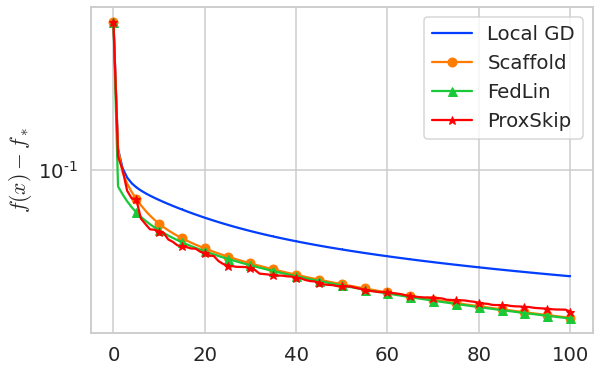

In [ ]:
sgd.trace.plot_losses(label='Local GD', marker=',')
scah.trace.plot_losses(label='Scaffold', marker='o')
fedlin.trace.plot_losses(label='FedLin', marker='^')
skip.trace.plot_losses(label='ProxSkip', marker='*', color='red')
plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.legend()

In [ ]:
loss.batch_smoothness(16)

2.400603932609272

In [ ]:
loss.smoothness

0.6611993844944798

In [17]:
class ProxSkip(StochasticOptimizer):
    """
    Stochastic gradient descent with decreasing or constant learning rate.
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, cohort_size=None, iid=False, lr0=None, lr_max=np.inf, lr_decay_coef=0,
                 lr_decay_power=1, it_start_decay=None, batch_size=1, losses=None, *args, **kwargs):
        super(ProxSkip, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        
        if self.cohort_size == self.n_workers:
            self.x = np.mean(ray.get([worker.run_local.remote(x_id, self.lr) for worker in self.workers]), axis=0)
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            self.x = np.mean(ray.get([self.workers[i].run_local.remote(x_id, self.lr) for i in cohort]), axis=0)
    
    def init_run(self, *args, **kwargs):
        super(ProxSkip, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        if self.lr0 is None:
            self.lr0 = 1 / self.loss.batch_smoothness(batch_size)
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, prox_skip=True, loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) for _ in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, prox_skip=True, loss=loss, it_local=self.it_local, batch_size=self.batch_size) for loss in loss_ids]
        
    def update_trace(self, first_iterations=10):
        super(ProxSkip, self).update_trace()
        
    def terminate_workers(self):
        for worker in self.workers:
            ray.kill(worker)

In [17]:
def abu_grad(list_x_0,list_y_0,eta_x,eta_y,beta_y,theta,L_x,T,M,K):
    history = []
    x = copy.deepcopy(list_x_0)
    history.append(x)
    y = copy.deepcopy(list_y_0)
    hat_y = copy.deepcopy(list_y_0)
    x_upd = copy.deepcopy(list_x_0)
    y_upd = copy.deepcopy(list_y_0)
    h = copy.deepcopy(list_y_0)
    m = copy.deepcopy(list_y_0)
    for t in range(T):
        v = copy.deepcopy(x)
        z = copy.deepcopy(list_x_0)
        for i in range(M):
            z[i] = x[i] - eta_x*aggr(hat_y,i)
            for k in range(K):
                v[i] = v[i] - (1/(L_x+(1/eta_x)))*(grad_f(v,i,losses)+(1/eta_x)*(v[i] - z[i]))
        
            x_upd[i] = x[i] - eta_x*(grad_f(v,i,losses)+aggr(hat_y,i))
            h[i] = aggr(y,i)+grad_f(v,i,losses)
            m[i] = x[i] - beta_y*h[i]
    
        for i in range(M):
            y_upd[i] = y[i]+eta_y*aggr(m,i)
            hat_y[i] = y_upd[i]+theta*(y_upd[i] - y[i])
        
        
        y = copy.deepcopy(y_upd)
        x = copy.deepcopy(x_upd)
        history.append(x)
        
    return x,y,history
            
        

In [18]:
list_x_0 = [x0]*n_workers

In [19]:
list_y_0 = [x0]*n_workers

In [20]:
list_hat_y = [x0]*n_workers

In [21]:
eta_x = 1/(4*(loss.smoothness*l2)**0.5)

In [22]:
eta_y = ((loss.smoothness*l2)**0.5)/(8*n_workers*n_workers)

In [23]:
eta_y

2.066112108331796e-06

In [24]:
beta_y = min(1/loss.smoothness,1/(2*eta_y))

In [25]:
beta_y

1.5125026311002856

In [26]:
theta = max( 2/(2+l2*eta_x) , 1-(n*n*beta_y*eta_y))

In [27]:
theta

0.9987515605493134

In [28]:
K_GD = 9*(1+(loss.smoothness/l2)**0.5)

In [29]:
K_GD

909.0

In [30]:
import numpy as np

In [31]:
def aggr(list_vec,my_index):
    res = len(list_vec)*(list_vec[my_index] - np.mean(list_vec,axis=0))
    return res

In [32]:
def grad_f(list_vec,my_index,losses):
    grad = losses[my_index].gradient(list_vec[my_index])
    return grad

In [34]:
x_f,y_f, history_f = abu_grad(list_x_0,list_y_0,eta_x,eta_y,beta_y,theta,loss.smoothness,4000,n_workers,int(K_GD))

In [35]:
loss_hist = []
for t in range(len(history_f)):
    mean_vec = np.array(np.mean(history_f[t],axis=0))
    loss_t = loss._value(mean_vec)
    loss_hist.append(loss_t - loss.f_opt)

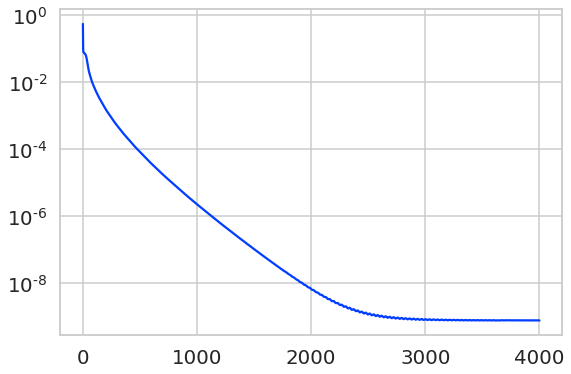

In [36]:
plt.plot(range(4001),loss_hist)
plt.yscale('log')

In [75]:
np.array(np.mean(history_f[-1],axis=0)).shape

(300,)

In [33]:
import copy

Text(0.5, 0, 'Communication rounds')

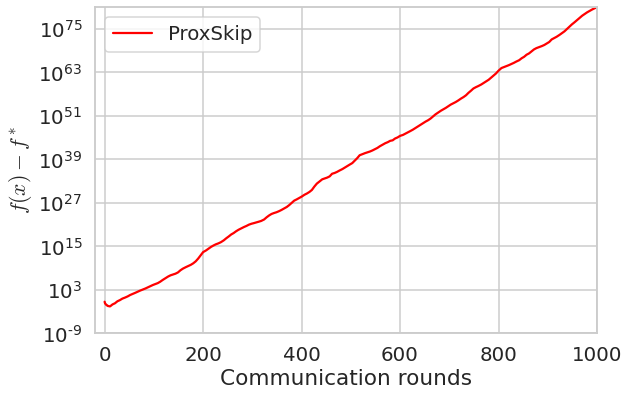

In [30]:

skip.trace.plot_losses(label='ProxSkip', color='red')
# rest.trace.plot_losses(label='NAG', color='blue')
# nest_true.trace.plot_losses(label='NAG', color='blue')
# plt.plot(loss_hist,label = 'APDA',color = 'green')
# plt.plot(loss_hist_f_a,label = 'acc-APDA',color = 'orange')
plt.ylim(bottom = 10**(-9))
plt.xlim(right = 1000)
plt.xlim(left = -20)
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Communication rounds')
# plt.savefig('ProxSKipvsNAG.pdf')

In [29]:
if batch_size is not None:
    it_local = (n-1) // batch_size + 1
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) / it_local
    it_max = n*5//(batch_size*it_local)
    skip_decay_coef = l2 / 2
else:
    it_local = 30 # same as for other methods
    skip_lr0 = 1 / (10*loss.smoothness)
    it_max = 1000 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
skip = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
skip.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip.trace.compute_loss_of_iterates()
skip.terminate_workers()

In [57]:
def acc_abu_grad(list_x_0,list_y_0,eta_x,eta_y,beta_y,theta,L_x,T,M,K):
    history = []
    x = copy.deepcopy(list_x_0)
    history.append(x)
    y = copy.deepcopy(list_y_0)
    hat_y = copy.deepcopy(list_y_0)
    x_upd = copy.deepcopy(list_x_0)
    y_upd = copy.deepcopy(list_y_0)
    h = copy.deepcopy(list_y_0)
    m = copy.deepcopy(list_y_0)
    for t in range(T):
        v = copy.deepcopy(x)
        v_upd = copy.deepcopy(x)
        w = copy.deepcopy(x)
        w_upd = copy.deepcopy(x)
        z = copy.deepcopy(list_x_0)
        for i in range(M):
            z[i] = x[i] - eta_x*aggr(hat_y,i)
            
            for k in range(int(K/2)):
                v_upd[i] = w[i] - (1/(L_x+(1/eta_x)))*(grad_f(w,i,losses)+(1/eta_x)*(w[i] - z[i]))
                a = (L_x+1/eta_x)**0.5 - (l2+1/eta_x)**0.5
                b = (L_x+1/eta_x)**0.5 + (l2+1/eta_x)**0.5
                w_upd[i] = v_upd[i] + (a/b)*(v_upd[i] - v[i])
                v[i] = copy.deepcopy(v_upd[i])
                w[i] = copy.deepcopy(w_upd[i])
            
            for k in range(int(K/2)):
                v[i] = v[i] - (1/(L_x+(1/eta_x)))*(grad_f(v,i,losses)+(1/eta_x)*(v[i] - z[i]))
        
            x_upd[i] = x[i] - eta_x*(grad_f(v,i,losses)+aggr(hat_y,i))
            h[i] = aggr(y,i)+grad_f(v,i,losses)
            m[i] = x[i] - beta_y*h[i]
    
        for i in range(M):
            y_upd[i] = y[i]+eta_y*aggr(m,i)
            hat_y[i] = y_upd[i]+theta*(y_upd[i] - y[i])
        
        
        y = copy.deepcopy(y_upd)
        x = copy.deepcopy(x_upd)
        history.append(x)
        
    return x,y,history

In [64]:
K_nest = ((20*64)**(1/3))*((1+(loss.smoothness/l2)**(0.5))**(2/3))

In [66]:
K_GD

909.0

In [67]:
x_f_a,y_f_a,history_f_a = acc_abu_grad(list_x_0,list_y_0,eta_x,eta_y,beta_y,theta,loss.smoothness,3000,n_workers,K_nest)

In [68]:
loss_hist_f_a = []
for t in range(len(history_f_a)):
    mean_vec_a = np.array(np.mean(history_f_a[t],axis=0))
    loss_t_a = loss._value(mean_vec_a)
    loss_hist_f_a.append(loss_t_a - loss.f_opt)

In [71]:
loss_hist_f_a_upd = []
for t in range(len(history_f_a)):
    mean_vec_a = np.array(np.mean(history_f_a[t],axis=0))
    for k in range(int(K_nest)):
        loss_t_a = loss._value(mean_vec_a)
        loss_hist_f_a_upd.append(loss_t_a - loss.f_opt)

In [74]:
loss_hist_ff_upd = []
for t in range(len(history_f)):
    mean_vec_a = np.array(np.mean(history_f[t],axis=0))
    loss_t_a = loss._value(mean_vec_a)
    for k in range(int(K_GD)):
        loss_hist_ff_upd.append(loss_t_a - loss.f_opt)

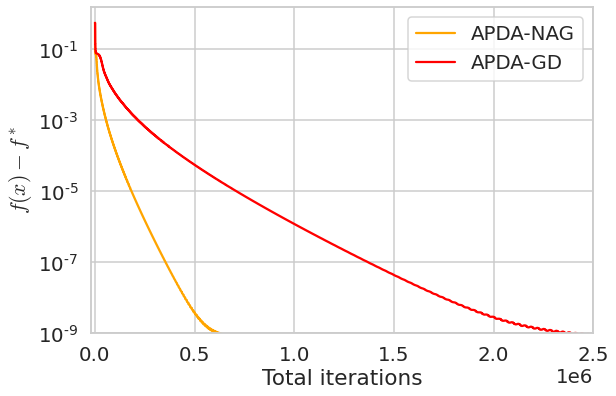

In [87]:
plt.plot(loss_hist_f_a_upd,label = 'APDA-NAG',color = 'orange')
plt.plot(loss_hist_ff_upd,label = 'APDA-GD',color = 'red')
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(bottom = 10**(-9))
plt.xlim(right = 2.5*10**(6))
plt.xlim(left = -20000)
plt.xlabel('Total iterations')
plt.ylabel('$ f(x) - f^*$')
plt.savefig('APDA_total.pdf')


In [20]:
from optmethods.first_order import Nesterov
nest_true = Nesterov(loss=loss, strongly_convex=True, mu=loss.l2, label='Nesterov acceleration')
nest_true_tr = nest_true.run(x0=x0, it_max=10000)
nest_true_tr.compute_loss_of_iterates()

In [21]:
nest_true.loss_vals = []

In [99]:
x_f_1,y_f_1, history_f_1 = abu_grad(list_x_0,list_y_0,4*eta_x,eta_y,beta_y,theta,loss.smoothness,1500,n_workers,int(K_GD))